# Лабораторная работа № 5. Решение задачи классификации на примере прогноза состояния системы на основе данных о состоянии ее компонентов.

В работе проводится ознакомление с различными методами машинного обучения с учителем, решающих задачу классификации. СОздаются различные линейные и нелинейные модели и оценивается точность из прогноза.

## Введение

Современные радиолокационные станции (РЛС) – это структурно-сложные радиотехнические и информационные системы, характеризующиеся высокой надежностью функционирования и большим числом цифровых компонентов в своем составе. Одним из таких компонентов является блок усиления мощности (БУМ), задача которого усиливать передаваемый или принимаемый сигнал.

Функционирование БУМ приводит к их нагреву, что может сказаться на снижении их работоспособности или даже привести к отказу. Под системой в этой работе мы будем понимать несколько БУМ, объединенных в единое целое. Тогда техническое состояние всей системы будет определяться техническим состоянием ее компонент, т.е. состоянием БУМ в данной работе. Техническое же состояние БУМ напрямую зависит от их температуры: при достижении определенного порога блок перестает работать и начинает охлаждаться. После охлаждения до определенной температуры он снова переходит в рабоспособное состояние.

Основная задача - спрогнозировать увеличение температуры блоков усиления мощности на основании истории их функционирования и режима работы блоков, который задает интенсивность нагрева, и возможный выход из строя всей системы блоков. В лабораторной работе № 3 проводится статистический анализ данных тепловой нагрузки модельных БУМ, определяются пороговые значения температур, при которых происходит отключение блоков с целью их охлаждения. На основании пороговых температур вычислено состояние блоков в интервале \[0, 1\] и установлен простой критерий определения состояния системы - снижение среднего состояния всех блоков ниже определенного порогового значения. 

В данной лабораторной работе будут применены различные методы машинного обучения с учителем для установления зависимости состояния системы от состояний блоков и прогноза состояния системы.

## Описание исходных данных

Подключим стандартные пакеты для работы с данными и построения графиков

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

Загрузим файл с данными и выведем на экран первые 5 строк. Получим информацию по каждой колонке.

In [2]:
df = pd.read_csv("Lab5_data.csv")
df.head(5)

,state1,state2,state3,state4,state5,state6,state7,state8,state9,system_state
0,0.990954,0.996330,1.000000,0.979060,1.000000,0.929844,0.947907,0.952991,0.962632,1.0
1,0.838641,0.806637,0.820733,0.813443,0.797077,0.736372,0.720410,0.780524,0.794755,1.0
2,0.821185,0.769370,0.830724,0.830488,0.813958,0.753848,0.715018,0.781899,0.796795,1.0
3,0.687686,0.604382,0.676615,0.708904,0.624583,0.638659,0.576266,0.615852,0.651636,1.0
4,0.583539,0.503571,0.578079,0.586587,0.534546,0.551319,0.487111,0.529548,0.518788,1.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205950 entries, 0 to 1205949
Data columns (total 10 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   state1        1205950 non-null  float64
 1   state2        1205950 non-null  float64
 2   state3        1205950 non-null  float64
 3   state4        1205950 non-null  float64
 4   state5        1205950 non-null  float64
 5   state6        1205950 non-null  float64
 6   state7        1205950 non-null  float64
 7   state8        1205950 non-null  float64
 8   state9        1205950 non-null  float64
 9   system_state  1205950 non-null  float64
dtypes: float64(10)
memory usage: 92.0 MB


Колонки **state1 - state9** содержат состояние блока 1 - 9 в виде вещественного числа в интервале \[0, 1\]. При этом значению 1 соответствует работоспособное состояние с минимальной температурой, в состоянию 0 - выключенное состояние, когда блок находится в режиме обхлаждения. Колонка **system_state** обозначает состояние системы: 1 - работоспособна, 0 - нерабоспособна. Все колонки имеют тип **float64**.

## Подготовка данных

Для использования моделей машинного обучения с учителем необходимо специальным образом подготовить данные: сформировать обучающую выборку, на которой модель будет "учиться", т.е. подстраивать свои внутренние параметры, тестовую выборку, на которой будет определяться точность модели в процессе ее обучения, а также валидационную выборку, на которой проверяется итогое качество работы модели. 

Вместо выделения валидационной выборки можно использовать механизм кросс-валидации.В основе метода лежит разделение исходного множества данных на **k** примерно равных блоков, например 5. Затем на **k-1**, т.е. на 4-х блоках, производится обучение модели, а 5-й блок используется для тестирования. Процедура повторяется **k** раз, при этом на каждом проходе для проверки выбирается новый блок, а обучение производится на оставшихся.
![Cross-validation](https://wiki.loginom.ru/images/cross-validation.svg)

Кросс-валидация имеет два основных преимущества перед применением одного множества для обучения и одного для тестирования модели:

- Распределение классов оказывается более равномерным, что улучшает качество обучения.
- Если при каждом проходе оценить выходную ошибку модели и усреднить ее по всем проходам, то полученная оценка будет более достоверной.

В дальнейшем в этой лабораторной работе будем использовать разбиение на 5 блоков с помощью метода **[KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html?highlight=k%20fold#sklearn.model_selection.KFold 'KFold')**.

In [4]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True)
X = df.loc[:, 'state1':'state9']
y = df['system_state'].astype(int)

for i, (train_index, test_index) in enumerate(kf.split(X), start=1):
    print('Fold {}'.format(i))
    print('Train index: ', train_index)
    print('Test index: ', test_index)

Fold 1
Train index:  [      0       1       3 ... 1205945 1205947 1205948]
Test index:  [      2      11      21 ... 1205940 1205946 1205949]
Fold 2
Train index:  [      1       2       4 ... 1205946 1205947 1205949]
Test index:  [      0       3       6 ... 1205941 1205945 1205948]
Fold 3
Train index:  [      0       1       2 ... 1205946 1205948 1205949]
Test index:  [      5      10      14 ... 1205938 1205944 1205947]
Fold 4
Train index:  [      0       1       2 ... 1205947 1205948 1205949]
Test index:  [      8      18      23 ... 1205933 1205936 1205942]
Fold 5
Train index:  [      0       2       3 ... 1205947 1205948 1205949]
Test index:  [      1       4       7 ... 1205920 1205925 1205943]


## Линейные модели машинного обучения

Задача определения состояния системы по известным состояниям блоков является задачей бинарной классификации. Среди линейных моделей будем использовать линейную регрессию, линейную регрессию с L1 и L2-регуляризацией, а также логистическую регрессию. Подробное описание работы этих моделей можно прочитать на сайте [Scikit Learn](https://scikit-learn.org/stable/modules/linear_model.html 'Scikit Learn').

#### **Задание 1** 

Сделаем процесс обучения различных моделей универсальным. Для этого напишем функцию **regr_accuracy(y_pred, y_test)**, которая будет считать точность спрогнизорованных значений целевой переменной для модели регрессии, функцию **class_accuracy(y_pred, y_test)**, которая будет считать точность спрогнизорованных значений целевой переменной для модели классификации, и функцию **train(model, model_name, evaluate, kfold, X, y)**, которая обучает заданную модель **model** с использованием механизма кросс-валидации **kfold**.

Точность - относительная доля правильно спрогнозированных значений.

In [5]:
X
kf.split(X)

<generator object _BaseKFold.split at 0x7f98c82b2190>

In [6]:
from sklearn.metrics import accuracy_score

# На основании пороговых
# температур вычислено состояние блоков в интервале [0, 1] и установлен простой
# критерий определения состояния системы - снижение среднего состояния всех
# блоков ниже определенного порогового значения.

# 1 - рабочее состояние, минимальная температура
# 0 - выключенное состояние, охлаждение
def my_round(data, threshhold = 0.5):
    data[data >= threshhold] = 1
    data[data <= threshhold] = 0
    return data


def regr_accuracy(y_pred, y_test):
    # y_pred - прогнозные значения
    # y_test - истинные значения
    
    # Точность приближения к определенному значению
    y_pred, y_test = my_round(y_pred), my_round(y_test)
    # Точность спрогнозированных значений целевой переменной для модели регрессии
    return accuracy_score(y_test, y_pred)

def class_accuracy(y_pred, y_test):
    # y_pred - прогнозные значения
    # y_test - истинные значения
    
    y_test = my_round(y_test).flatten()
    # Связи между зависимой переменной и независимыми при условии, что
    # Это выражение будет иметь статистическую значимость
    return accuracy_score(y_test, y_pred)

# Обучает заданную модель model с использованием кросс-валидации
def train(model, model_name, evaluate, kfold, X, y):
    # model - модель для прогноза, обладающая методами fit(), predict()
    # model_name - название модели, строковый тип
    # evaluate - функция для расчета точности, например функция regr_accuracy() или class_accuracy()
    # kfold - объект KFold
    # X - признаки
    # y - целевая переменная
    print('Train model: '+ model_name)
    scores = []
    for train_index, test_index in kfold.split(X):
        # Обучение модели на обучающей выборке
        model.fit(X.iloc[train_index].to_numpy(), y.iloc[train_index].to_numpy())
        # Прогнозирование меток значений данных на основе обученной модели по признаку X
        y_pred = model.predict(X.iloc[test_index].to_numpy())
        scores.append(evaluate(y_pred, y.iloc[test_index].to_numpy()))
    
    print("scores=", scores)
    mean_score = np.mean(scores)
    print('Mean score = {:.5f}'.format(mean_score))
    return mean_score

### Линейная регрессия

В линейных моделях целевая переменная $\hat{y}$ определяется как линейная комбинация известных переменных (признаков):

$$\hat{y}(w, x) = w_0 + w_1 x_1 + ... + w_p x_p$$

В модели линейной регрессии коэффициенты $w = (w_1, ..., w_p)$ подбираются таким образом, чтобы минимизировать сумму квадратов отклонений рассчитанных значений целевой переменной от истинных значений:

$$\min_{w} || X w - y||_2^2$$

Важно отметить, что линейные модели чувствительны к абсолютным значениям признаков, поэтому следует перед применением линейных моделей провести нормирование исходных данных (обычно на интервал \[0,1\]). Также применение линейных моделей основано на предположении о линейной независимости признаков, поэтому следует стараться не использовать в качестве признаков коррелированные признаки. В противном случае модель будет чувствительна к шумам, т.е. случайным выбросам в значениях признаков.

Создадим и обучим модель **[LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression 'LinearRegression')**. Запишем точность модели в словарь **scores**.

In [7]:
from sklearn import linear_model

lin_reg = linear_model.LinearRegression()

scores = dict()

score = train(lin_reg, 'linear regression', regr_accuracy, kf, X, y)
scores['linear regression'] = score

Train model: linear regression
scores= [0.8378208051743439, 0.8384468676147435, 0.8365230730958995, 0.8380612794891994, 0.8363199137609354]
Mean score = 0.83743


### Линейная регрессия c L1 и L2 регуляризацией

Если размер обучающей выборки невелик, а число признаков, наоборот, достаточно велико, то коэффициенты модели могут быть подобраны таким образом, чтобы модель максимально точно учитывала все точки из обучающей выборки, при этом вне обучающей выборки модель будет давать большую ошибку. Это явление носит название переобучения. Одним из способов препятствовать переобучению является механизмы регуляризации. Он ограничивает значения коэффицентов $w = (w_1, ..., w_p)$, используемых в модели.

L1-регуляризация вносит дополнительный "штраф", пропорциональный модулю значения коэффициента:
$$\min_{w} ||X w - y||_2 ^ 2 + \alpha ||w||_1$$

L2-регуляризация вносит дополнительный "штраф", пропорциональный квадрату модуля значения коэффициента:
$$\min_{w} || X w - y||_2^2 + \alpha ||w||_2^2$$

Параметр $\alpha$ задает "силу" регуляризации. L1-регуляризация приведет к тому, что все несущественные признаки будут иметь вес, равный 0. L2-регуляризация приведет к тому, что несущественные признаки будут иметь околонулевые веса. Продемонстрируем это на примере. Создадим и обучим модели **[Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso 'Lasso')** (L1-регуляризация) и **[Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge 'Ridge')** (L2-регуляризация).

Подберите оптимальное значения параметра регуляризации **$\alpha$** для модели **Lasso**.

#### **Задание 2** 

In [8]:
for alpha in [1e-4, 1e-3, 0.01, 0.1, 1]:
    print('Alpha = {}'.format(alpha))
    
    # Линейная модель, обученная с помощью L1 в качестве регуляризатора
    lasso = linear_model.Lasso(alpha=alpha)
    res = train(lasso, 'lasso', regr_accuracy, kf, X, y)    
    print('Coefficients: ', lasso.coef_)

Alpha = 0.0001
Train model: lasso
scores= [0.8374932625730752, 0.8372403499315892, 0.8372486421493428, 0.8374891164641983, 0.8378581201542352]
Mean score = 0.83747
Coefficients:  [0.16611363 0.16985441 0.16683699 0.15935249 0.16891744 0.16618553
 0.16596189 0.17001374 0.17101742]
Alpha = 0.001
Train model: lasso
scores= [0.8364277125917327, 0.8378498279364817, 0.8380861561424603, 0.8373730254156474, 0.8374891164641983]
Mean score = 0.83745
Coefficients:  [0.16338235 0.16713393 0.16442686 0.15777969 0.1665722  0.16613039
 0.16261356 0.16713814 0.17063384]
Alpha = 0.01
Train model: lasso
scores= [0.8359882250507898, 0.8345205025083958, 0.8360048094862971, 0.8359716406152825, 0.8366972096687258]
Mean score = 0.83584
Coefficients:  [0.14153659 0.14485679 0.14161098 0.13634622 0.14714832 0.14584239
 0.14214964 0.14594693 0.14886802]
Alpha = 0.1
Train model: lasso
scores= [0.6520170819685724, 0.6528338654173058, 0.653472366184336, 0.653289937393756, 0.6531821385629587]
Mean score = 0.65296
C

Обучим модель с оптимальным значением параметра $\alpha$. Сохраним точность прогноза в словаре **scores**.

In [9]:
lasso = linear_model.Lasso(alpha = 0.001)
score = train(lasso, 'lasso', regr_accuracy, kf, X, y)
scores['lasso'] = score

Train model: lasso
scores= [0.8376632530370247, 0.837634230274887, 0.8365064886603922, 0.8380654255980762, 0.8373066876736183]
Mean score = 0.83744


#### **Задание 3** 

Подберите оптимальное значения параметра регуляризации **$\alpha$** для модели **Ridge**.

In [10]:
for alpha in [1e-4, 1e-3, 0.01, 0.1, 1]:
    print('Alpha = {}'.format(alpha))
    
    ridge = linear_model.Ridge(alpha=alpha)
    res = train(ridge, 'ridge', regr_accuracy, kf, X, y)
    print('Coefficients: ', ridge.coef_)

Alpha = 0.0001
Train model: ridge
scores= [0.8373937559600315, 0.836556241966914, 0.8382188316265186, 0.8376176458393797, 0.8374766781375679]
Mean score = 0.83745
Coefficients:  [0.16646265 0.16945439 0.16529261 0.16147182 0.16784375 0.16874532
 0.16642235 0.17049811 0.17149926]
Alpha = 0.001
Train model: ridge
scores= [0.8374642398109374, 0.8388614785024254, 0.8367884240640159, 0.8368754923504291, 0.8373191260002487]
Mean score = 0.83746
Coefficients:  [0.16630897 0.16956196 0.16545793 0.161264   0.16846443 0.16758515
 0.16582592 0.170009   0.17182077]
Alpha = 0.01
Train model: ridge
scores= [0.837704714125793, 0.8371491355362992, 0.837841535718728, 0.836373813176334, 0.8382437082797795]
Mean score = 0.83746
Coefficients:  [0.16473206 0.1690088  0.1664682  0.16142316 0.1692559  0.16979253
 0.16459267 0.17040543 0.17124416]
Alpha = 0.1
Train model: ridge
scores= [0.8372569343670965, 0.8376964219080393, 0.8373440026535097, 0.8376549608192712, 0.8371657199718064]
Mean score = 0.83742
Coe

Обучим модель с оптимальным значением параметра $\alpha$. Сохраним точность прогноза в словаре **scores**.

In [11]:
ridge = linear_model.Ridge(alpha = 0.001)
score = train(ridge, 'ridge', regr_accuracy, kf, X, y)
scores['ridge'] = score

Train model: ridge
scores= [0.8379659189850326, 0.8380820100335835, 0.8377917824122062, 0.8371574277540528, 0.8362950371076745]
Mean score = 0.83746


Как видим, **Lasso** просто занулила все коэффициенты при $\alpha>0.01$.

### Логистическая регрессия

Если на выходе линейной регрессии получается просто вещественное число, то в логистической регрессии это число преобразуется с помощью логистической функции в отрезок \[0,1\], а потому может трактоваться как вероятность получения на выходе дискретного значения 1. 

$$f(y)=\dfrac{1}{1+e^{-y}}$$

Таким образом, модель логистической регрессии может успешно использоваться как бинарный классификатор. Логистическая регрессия минимизирует следующую величину (L1 и L2 регуляризация уже включены и контролируются параметрами $C$ - "сила" регуляризации (малые значения - "сильная" регуляризация), $\rho$ - относительный вклад L1-регуляризации):

$$\min_{w, c} \frac{1 - \rho}{2}w^T w + \rho \|w\|_1 + C \sum_{i=1}^n \log(\exp(- y_i (X_i^T w + c)) + 1)$$

Создадим модель **[LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression 'Logistic Regression')** и обучим ее.

Подберите оптимальное значение параметра регуляризации **С** и тип регуляризации **penalty**. 

#### **Задание 4** 

In [12]:
for C in [1e-4, 1e-3, 0.01, 0.1, 1]:
    for penalty in ['l2']:
        logistic_regr = linear_model.LogisticRegression(penalty=penalty, C=C, solver='lbfgs')
        res = train(logistic_regr, f'logistic_regression_C_{C}_penalty_{penalty}', regr_accuracy, kf, X, y)

Train model: logistic_regression_C_0.0001_penalty_l2
scores= [0.8356150752518761, 0.835938471744268, 0.8368754923504291, 0.836601849164559, 0.835963348397529]
Mean score = 0.83620
Train model: logistic_regression_C_0.001_penalty_l2
scores= [0.8369501223102118, 0.838484182594635, 0.8385422281189104, 0.8360628550105725, 0.8373025415647415]
Mean score = 0.83747
Train model: logistic_regression_C_0.01_penalty_l2
scores= [0.8362950371076745, 0.8373647331978937, 0.8373274182180024, 0.8384054065259754, 0.8375181392263361]
Mean score = 0.83738
Train model: logistic_regression_C_0.1_penalty_l2
scores= [0.8374186326132924, 0.8371325511007919, 0.8380737178158298, 0.8370910900120238, 0.8372569343670965]
Mean score = 0.83739
Train model: logistic_regression_C_1_penalty_l2
scores= [0.8375388697707202, 0.8381317633401053, 0.8372403499315892, 0.8368713462415523, 0.8374144865044156]
Mean score = 0.83744


Обучим модель с оптимальным значением параметра **С**. Сохраним точность прогноза в словаре **scores**.

In [13]:
logistic_regr = linear_model.LogisticRegression(penalty = 'l2', C=0.001, solver='lbfgs')
score = train(logistic_regr, 'logistic regression', class_accuracy, kf, X, y)
scores['logistic regression'] = score

Train model: logistic regression
scores= [0.8378290973920975, 0.8380861561424603, 0.8381234711223516, 0.8362701604544135, 0.8369128073303205]
Mean score = 0.83744


## Метод опорных векторов

Этот метод применим для решения как задач классификации, так и регрессии, и кластеризации. Основными достоинствами метода являются:

- эффективность при большой размерности пространства признаков
- в процессе обучения запоминается только подвыборка обучающей выборки - опорные вектора, т.е. требует меньший объем памяти
- можно применять разные ядра (kernels) для формирования модели

Недостатком метода опорных векторов является то, что в случае, когда размерность пространства признаков много больше объема обучающей выборки, на результат работы модели сильно влияет выбор ядра. Также этот метод не позволяет быстро и просто получить вероятность прогноза.

С математической точки зрения, метод опорных векторов проводит гипер-плоскость, которая разделяет один класс от другого. При этом граница проводится так, что быть расположенной максимально далеко от каждой из точек.
![SVC](https://scikit-learn.org/stable/_images/sphx_glr_plot_separating_hyperplane_0011.png)

Функция ядра определяет, какие признаки будут использоваться в качестве переменных в гиперпространстве, в котором проводится гипер-плоскость. Например, для линейного ядра $\langle x, x'\rangle$ берутся исходные признаки, для полиномиального ядра - полиномы от исходных признаков $(\gamma \langle x, x'\rangle + r)^d$, для radial-basis-function (rbf) - экспоненциальная функция $\exp(-\gamma \|x-x'\|^2)$.

Построим модель Support Vector Classifier - [**SVC**](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC 'SVC') для различных ядер. Заранее уменьшим размер выборки, что позволит проводить обучения в разумное время (метод опорных векторов довольно долго обучается).

Определите оптимальное значение параметра регуляризации **С** и типа ядра **kernel**.

#### **Задание 5**

In [14]:
from sklearn.svm import SVC
X_svc = X.iloc[:10000, :]
y_svc = y[:10000]

for C in [1e-4, 1e-3, 0.01, 0.1, 1]:
    for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
        svc = SVC(kernel=kernel, C=C)
        res = train(svc, f'svc_C_{C}_kernel_{kernel}', class_accuracy, kf, X_svc, y_svc)

Train model: svc_C_0.0001_kernel_linear
scores= [0.665, 0.6345, 0.644, 0.645, 0.66]
Mean score = 0.64970
Train model: svc_C_0.0001_kernel_poly
scores= [0.812, 0.81, 0.7965, 0.808, 0.813]
Mean score = 0.80790
Train model: svc_C_0.0001_kernel_rbf
scores= [0.6565, 0.6595, 0.636, 0.65, 0.6465]
Mean score = 0.64970
Train model: svc_C_0.0001_kernel_sigmoid
scores= [0.665, 0.643, 0.6485, 0.647, 0.645]
Mean score = 0.64970
Train model: svc_C_0.001_kernel_linear
scores= [0.8085, 0.8085, 0.807, 0.8075, 0.81]
Mean score = 0.80830
Train model: svc_C_0.001_kernel_poly
scores= [0.8225, 0.8135, 0.8335, 0.8475, 0.827]
Mean score = 0.82880
Train model: svc_C_0.001_kernel_rbf
scores= [0.6375, 0.651, 0.652, 0.6535, 0.6555]
Mean score = 0.64990
Train model: svc_C_0.001_kernel_sigmoid
scores= [0.644, 0.6435, 0.6655, 0.653, 0.6425]
Mean score = 0.64970
Train model: svc_C_0.01_kernel_linear
scores= [0.831, 0.837, 0.8205, 0.834, 0.823]
Mean score = 0.82910
Train model: svc_C_0.01_kernel_poly
scores= [0.8455, 

Обучим модель с оптимальным значением параметра **С** и типом ядра **kernel**. Сохраним точность прогноза в словаре **scores**.

In [15]:
svc = SVC(C=1, kernel='rbf', gamma='auto')
score = train(svc, 'svc', class_accuracy, kf, X_svc, y_svc)
scores['svc'] = score

Train model: svc
scores= [0.8495, 0.8505, 0.8415, 0.848, 0.833]
Mean score = 0.84450


## Дерево решений

В модели дерева решений (Decision Tree) в процессе обучения строится алгоритм, по которому выполняется прогноз модели. При этом алгоритм представляет из себя дерево, каждый лист которого - это проверка на то, что какой-либо признак из обучающей выборки принимает определенное значение. Пример дерева решений приведен на рисунке ниже.
![Decision Tree](https://scikit-learn.org/stable/_images/sphx_glr_plot_iris_dtc_0021.png)

Преимуществами такого метода являются:
- простота визуализации и хорошая интерпретируемость алгоритма прогноза
- не требуется нормализация данных
- скорость прогноза пропорциональна логарифму объема выборки, т.е. этот метод быстрый
- может обрабатывать как числовые, так и категориальные данные

Недостатками метода являются:
- деревья легко переобучаются
- небольшие изменения в обучающей выборке могут привести к перестойке всего дерева, т.е. метод нестабилен
- предсказания деревьев являются кусочно-постоянными, поэтому не годятся для экстраполирования
- требуется сбалансировать обучающую выборку по классам, чтобы не допустить "перекоса" дерева в сторону какого-либо класса

Конкретную математическую реализалицаю алгоритма построения дерева решений можно изучить, например, [здесь.](https://scikit-learn.org/stable/modules/tree.html)

Создадим модель [**DecisionTreeClassifier**](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier 'DecisionTreeClassifier') и обучим ее. Для того, чтобы предотвратить переобучение дерева, обычно ограничивается максимальная глубина дерева - параметр **max_depth**, а также минимальное число элементов из обучающей выборки, приходящееся на определнный лист, чтобы можно было с него сделать новое ветвление - параметр **min_samples_split**.

Подберите оптимальное значение параметров **max_depth** и **min_samples_split**.

#### **Задание 6** 

In [16]:
from sklearn.tree import DecisionTreeClassifier

from sklearn.tree import DecisionTreeClassifier

for max_depth in [1, 3, 5, 7]:
    for min_samples_split in [0.1, 0.3, 0.5, 3, 5, 7, 9, 11]:
        dtc = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split, \
                                    min_samples_leaf=1, random_state=0)
        res = train(dtc, f'decision_tree_max_depth_{max_depth}_min_samples_split_{min_samples_split}', \
                    class_accuracy, kf, X, y)

Train model: decision_tree_max_depth_1_min_samples_split_0.1
scores= [0.7399145901571376, 0.7406774741904723, 0.7397072847132966, 0.7392553588457232, 0.7393880343297815]
Mean score = 0.73979
Train model: decision_tree_max_depth_1_min_samples_split_0.3
scores= [0.7413657282640242, 0.7389775695509764, 0.7404162693312326, 0.7401136033832248, 0.7397694763464489]
Mean score = 0.74013
Train model: decision_tree_max_depth_1_min_samples_split_0.5
scores= [0.7424312782453667, 0.7382602927152867, 0.7402131099962685, 0.7405572370330444, 0.7394377876363033]
Mean score = 0.74018
Train model: decision_tree_max_depth_1_min_samples_split_3
scores= [0.7398606907417389, 0.7411169617314151, 0.739446079854057, 0.7390397611841287, 0.7404950453998922]
Mean score = 0.73999
Train model: decision_tree_max_depth_1_min_samples_split_5
scores= [0.7394129109830424, 0.740316762718189, 0.7399394668103985, 0.7391765827770638, 0.7408474646544219]
Mean score = 0.73994
Train model: decision_tree_max_depth_1_min_samples_

Создадим модель с оптимальными значениями параметров **max_depth** и **min_samples_split**. Добавим ее в словарь **scores**.

In [17]:
dtc = DecisionTreeClassifier(max_depth=7, min_samples_split=11, min_samples_leaf=1, random_state=0)
score = train(dtc, 'decision tree', class_accuracy, kf, X, y)
scores['decision tree'] = score

Train model: decision tree
scores= [0.841369874372901, 0.8430241718147519, 0.8415191342924665, 0.8417430241718148, 0.8426427297980845]
Mean score = 0.84206


## Сравнение различных моделей

Отобразим на графике точность работы каждой построенной модели. Для этого будем использовать значения из словаря **scores**.

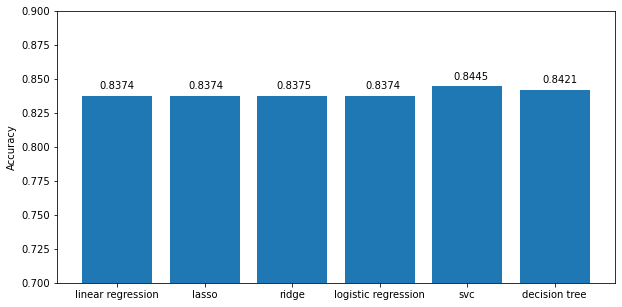

In [18]:
plt.figure(figsize=(10,5))
xx = list(scores.keys())
yy = list(scores.values())
rects = plt.bar(xx, yy)
plt.ylim(0.7, 0.9)
plt.ylabel('Accuracy')
for i, rect in enumerate(rects):
    yloc = rect.get_height()
    xloc = rect.get_x() + rect.get_width() / 4
    plt.annotate(round(yy[i], 4), xy=(xloc, yloc), xytext=(xloc, 10),
                            textcoords="offset points",
                            va='center',
                            color='black', clip_on=True)

# Выводы

#### **Задание 7** 

Напишите выводы по лабораторной работе

**Все модели показали примерно одинаковый результат точности предсказания. Лучший результат показал метод опорных векторов**